In [1]:
import matplotlib.pyplot as plt
from IPython.display import Math, display
import numpy as np
import sympy as sp
from scipy import constants as const
from scipy import sparse
from scipy.optimize import minimize_scalar

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from twod_trap import DoubleTweezer

## Trap parameters:

In [2]:
initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 0.808*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist,     #transfer tweezer
    distance_tweezers = initial_distance,

    m= 161 * const.value("atomic mass constant"),
    a_s= 85* const.value("Bohr radius"),
    mu_b= 9.93 * const.value("Bohr magneton" ),
    a= 184*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 1064 * si.nm,

    g = 0,
)

omega_z1 = sp.sqrt(4*trap.power_tweezer1*trap.a/sp.pi**3/trap.m) * trap.wvl/trap.waist_tweezer1**3
omega_z2 = sp.sqrt(4*trap.power_tweezer2*trap.a/sp.pi**3/trap.m) * trap.wvl/trap.waist_tweezer2**3

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer2**2

print(f"omega_r1: {float(trap.subs(omega_r1)/2/np.pi):.1f}Hz, omega_r2: {float(trap.subs(omega_r2)/2/np.pi):.1f}Hz")
print(f"omega_z1: {float(trap.subs(omega_z1)/2/np.pi):.1f}Hz, omega_z2: {float(trap.subs(omega_z2)/2/np.pi):.1f}Hz")

omega_r1: 2169.9Hz, omega_r2: 2169.9Hz
omega_z1: 472.4Hz, omega_z2: 472.4Hz


depth 1: 0.2778 Hz
depth 2: 0.2778 Hz
target trap frequency x: 3000.00 HZ
trapping frequency x 1: 1061.62 Hz
trapping frequency x 2: 1061.62 Hz
trapping frequency y 1: 3387.98 Hz
trapping frequency y 2: 3387.98 Hz
trapping frequency z 1: 546.57 Hz
trapping frequency z 2: 546.57 Hz
harmonic oscillator length x: 243.18 nm
harmonic oscillator length z: 338.91 nm
tunneling distance: 0.00 nm


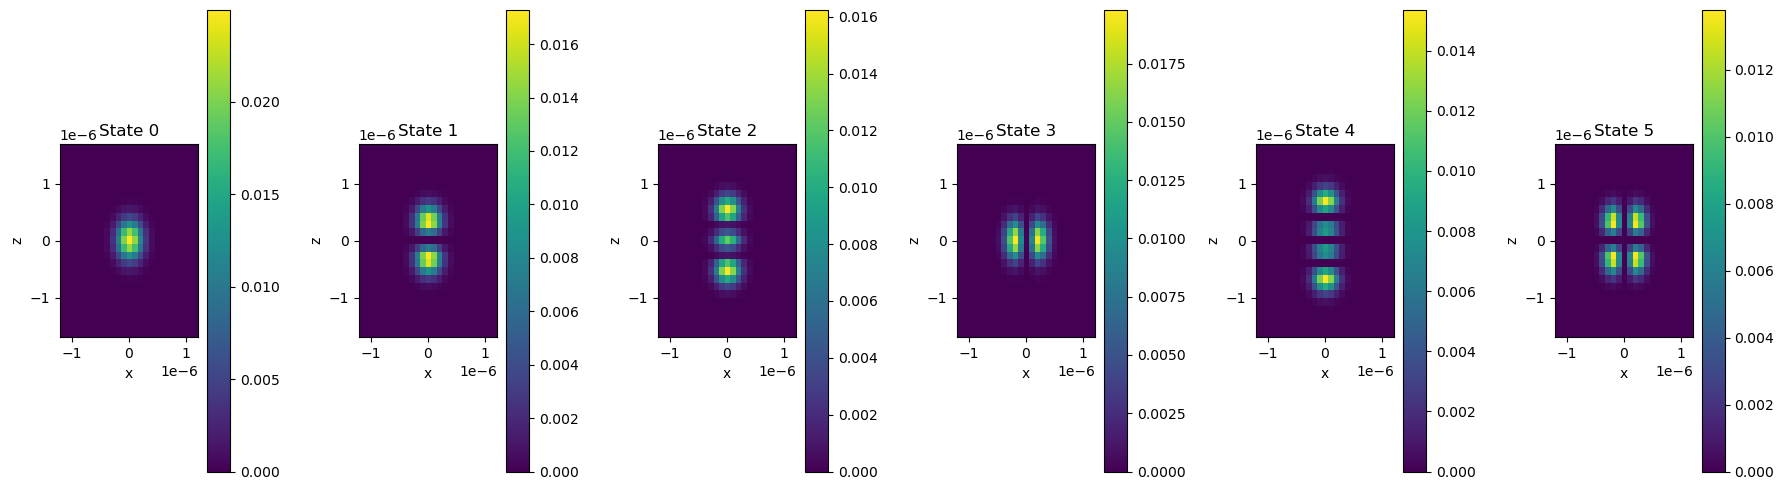

_________________________________________________________________
depth 1: 2012.3643 Hz
depth 2: 2086.0124 Hz
target trap frequency x: 3000.00 HZ
trapping frequency x 1: 2022.19 Hz
trapping frequency x 2: 2022.19 Hz
trapping frequency y 1: 3149.18 Hz
trapping frequency y 2: 3149.18 Hz
trapping frequency z 1: 576.15 Hz
trapping frequency z 2: 576.15 Hz
harmonic oscillator length x: 176.20 nm
harmonic oscillator length z: 330.10 nm
tunneling distance: 916.91 nm


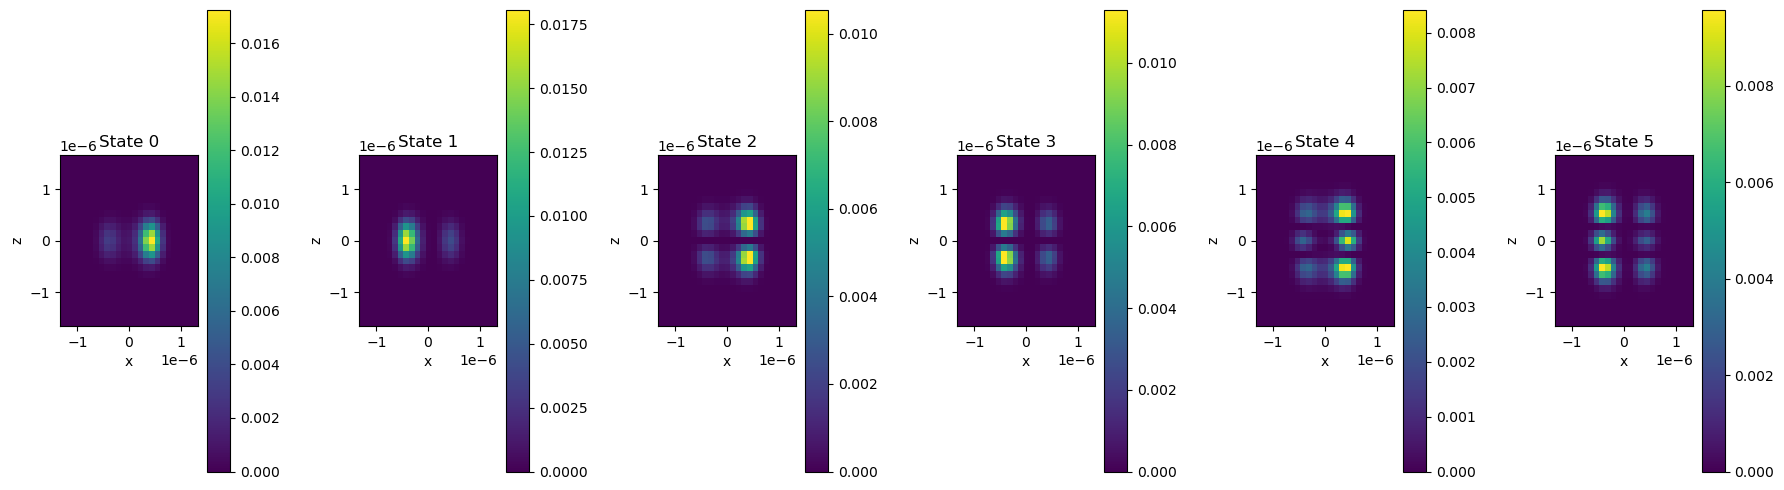

_________________________________________________________________
depth 1: 8370.8575 Hz
depth 2: 8284.3949 Hz
target trap frequency x: 3000.00 HZ
trapping frequency x 1: 2619.39 Hz
trapping frequency x 2: 2619.39 Hz
trapping frequency y 1: 3056.76 Hz
trapping frequency y 2: 3056.76 Hz
trapping frequency z 1: 619.72 Hz
trapping frequency z 2: 619.72 Hz
harmonic oscillator length x: 154.81 nm
harmonic oscillator length z: 318.28 nm
tunneling distance: 1328.43 nm


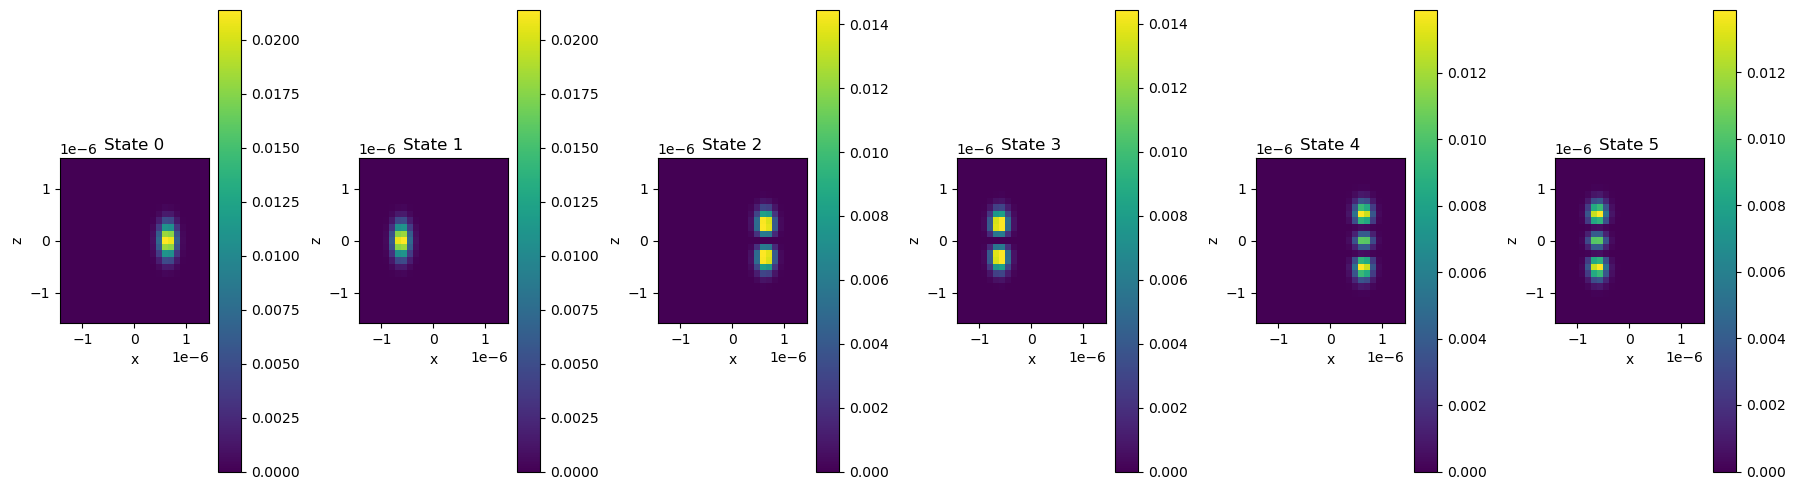

_________________________________________________________________


In [ ]:
#define trap frequencies to look at
trap_freqs = np.array([3*si.kHz])*2*np.pi
#find good separation for all frequencies

#calculate corresponding power
trap_powers = np.zeros_like(trap_freqs)
for i, freq in enumerate(trap_freqs):
    trap_powers[i] = float(trap.subs(trap.m*trap.waist_tweezer1**4*sp.pi*freq**2/8/trap.a))
    harm_osc_len_est = float(trap.subs(sp.sqrt(const.hbar/trap.m/freq)))

    trap[trap.power_tweezer1] = trap_powers[i]
    trap[trap.power_tweezer2] = trap_powers[i]
    
    dist0 = float(trap.subs(trap.waist_tweezer1)) + harm_osc_len_est
    trap_spacings = np.linspace(dist0 -200*si.nm, dist0 +200*si.nm, 3)
    #loop over distances
    for j, dist in enumerate(trap_spacings):

        trap[trap.distance_tweezers] = dist

        
        ##################
        #print trap parameters
        V = trap.subs(trap.get_potential(apply_zero_offset=False))
        a = float(trap.subs(trap.distance_tweezers))

        #find minima of potential
        def V_func(x):
            return float(V.subs({trap.x:x, trap.y:0, trap.z:0}))

        x_right = minimize_scalar(V_func,bracket=[0,a]).x
        x_left = minimize_scalar(V_func,bracket=[-a,0]).x

        #catch case where both potentials have already merged
        tunneling_dist = abs(x_right-x_left)
        if tunneling_dist < 1e-15:
            continue
            #raise Exception("potential has only one minimum")

        #depts of both tweezers
        V_1 = abs(V_func(x_left) - V_func(0))
        V_2 = abs(V_func(x_right) - V_func(0)) 

        #trapping frequencies
        omega_x1, omega_x2 = trap.get_both_omega(trap.x)
        omega_y1, omega_y2 = trap.get_both_omega(trap.y)
        omega_z1, omega_z2 = trap.get_both_omega(trap.z)

        harm_osc_len_x = float(trap.subs(sp.sqrt(const.hbar/trap.m/omega_x1)))
        harm_osc_len_z = float(trap.subs(sp.sqrt(const.hbar/trap.m/omega_z1)))

        #print results
        print(f"depth 1: {V_1/const.h:.4f} Hz")
        print(f"depth 2: {V_2/const.h:.4f} Hz")
        #print(f"estimated tilt: {abs(V_1 - V_2)/const.h:.2f} Hz")

        print(f"target trap frequency x: {freq/2/np.pi:.2f} HZ")
        print(f"trapping frequency x 1: {trap.subs(omega_x1)/2/np.pi:.2f} Hz")
        print(f"trapping frequency x 2: {trap.subs(omega_x2)/2/np.pi:.2f} Hz")
        print(f"trapping frequency y 1: {trap.subs(omega_y1)/2/np.pi:.2f} Hz")
        print(f"trapping frequency y 2: {trap.subs(omega_y2)/2/np.pi:.2f} Hz")
        print(f"trapping frequency z 1: {trap.subs(omega_z1)/2/np.pi:.2f} Hz")
        print(f"trapping frequency z 2: {trap.subs(omega_z2)/2/np.pi:.2f} Hz")

        print(f"harmonic oscillator length x: {harm_osc_len_x/si.nm:.2f} nm")
        print(f"harmonic oscillator length z: {harm_osc_len_z/si.nm:.2f} nm")
        print(f"tunneling distance: {tunneling_dist/si.nm:.2f} nm")

        #############
        #test 3D diag

        n_grid_1D = 25  

        n_pot_steps = [n_grid_1D,n_grid_1D,n_grid_1D]
        n_levels = 6

        left_cutoff = -0.5*tunneling_dist-5*harm_osc_len_x
        right_cutoff = 0.5*tunneling_dist+5*harm_osc_len_x
        back_cutoff = -5*harm_osc_len_x
        front_cutoff = 5*harm_osc_len_x
        bottom_cutoff = -5*harm_osc_len_z
        top_cutoff = 5*harm_osc_len_z

        extend = [(left_cutoff,right_cutoff),
                (back_cutoff,front_cutoff),
                (bottom_cutoff,top_cutoff)]
        
        # Solve the hamiltonian numerically
        energies, states, potential, coords = trap.nstationary_solution(
                [trap.x,trap.y,trap.z], extend, n_pot_steps, k=n_levels,
                method="matrix_free", export=False)

        x = coords[trap.x]
        y = coords[trap.y]
        z = coords[trap.z]
        x3D,y3D,z3D = np.meshgrid(coords[trap.x],coords[trap.y],coords[trap.z],indexing="ij")
        pot = potential(x3D,y3D,z3D)

        n_states = 6

        # Create a 1xn_states grid of subplots (1 row, n_states columns)
        fig, axes = plt.subplots(1, n_states, figsize=(18/6*n_states, 5))  # Adjust the size as needed

        # Loop over the state numbers from 0 to 5
        for state_number, ax in zip(range(n_states), axes):
            # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
            im = ax.imshow(np.abs(states[state_number, :, int(len(y)/2), :].T)**2, extent=[*extend[0], *extend[2]], origin="lower",
                        vmin=np.min(np.abs(states[state_number])**2), vmax=np.max(np.abs(states[state_number])**2))

            # Set labels for each subplot
            ax.set_xlabel("x")
            ax.set_ylabel("z")
            ax.set_title(f"State {state_number}")
            fig.colorbar(im, ax=ax)  

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plots
        plt.show()

        print("_________________________________________________________________")

In [4]:
trap_spacings/si.uW

array([1.04466052, 1.24466052, 1.44466052])